In [1]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [17]:
def plot_images(image_left, image_right):
    plt.subplot(1, 2, 1)
    plt.title("image left")
    plt.imshow(image_left, "gray")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("image right")
    plt.imshow(image_right, cmap="gray")
    plt.colorbar()

def step0_load_image(filename):
    image = read_image(filename)
    return image

def step1_get_roimage(image, topleft, bottomright, rotation):
    roi_image, roi = get_roi(image, topleft, bottomright)
    roi_image = rotate(roi_image, rotation)
    return roi_image, roi

def get_derivative(roi_image):
    deriv = roi_image
    return roi_image

def plot_derivatives(deriv):
    plt.subplot(1, 2, 1)
    plt.title("LSF for all rows")
    for i in range(deriv.shape[0]):
        plt.plot(deriv[i, :])
    
    plt.subplot(1, 2, 2)
    plt.title("LSF for first row")
    plt.plot(deriv[0,:])      

def get_fit(curve):
    x = np.arange(len(curve))
    y = curve
    fit = get_polyfit(x, y, 1)
    return fit
    
def step4_get_centroid_and_fit(deriv, hamming_win):
    centroid = get_centroid(deriv * hamming_win) - 0.5
    fit = get_fit(centroid)
    return centroid, fit

def plot_centroid(image, centroid, fit):
    plt.title("LSF and fittings")
    plt.imshow(image)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid

    plt.plot(np.polyval(fit, x), x, "y")

def plot_lsf(lsf_curve, centroid, fit, roi_image_limited):
    plt.subplot(1, 2, 1)
    plt.title("LSF after Hamming window")
    plt.imshow(lsf_curve)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid
    plt.plot(np.polyval(fit, x), x, "y")

    plt.subplot(1, 2, 2)
    plt.title("LSF limted")
    plt.imshow(roi_image_limited)

def step5_fit_central(fit, centroid, deriv_v, win1_v):
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    hamming_width = deriv_v.shape[1]

    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    deriv_hamming_windowed = deriv_v*win2

    centroid, fit = step4_get_centroid_and_fit(deriv_hamming_windowed, win1_v)

    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi

    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv_v.shape[0]/2)

    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv_v.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)

    roi_image_limited = deriv_hamming_windowed[:nlin1, :]

    # plot_lsf(deriv_hamming_windowed, centroid, fit, roi_image_limited)

    vslope = -fit[0]
    slope_deg = slout
    delimage = 1

    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))

    # input pixel sampling normal to edge
    del1n = delfac
    nbin = 4
    # super-sampling interval normal to edge
    del2 = del1n/nbin

    nn = math.ceil(deriv_hamming_windowed.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1

    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)

    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)

    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    return roi_image_limited, nbin, nn2, del2

def step6_super_sample(roi_image_limited, fit, nbin):
    esf = project2(roi_image_limited, fit, nbin)
    l = len(esf)
    esf[l-1] = esf[l-2]
    return esf

def step7_get_lsf(esf):
    lsf1 = esf
    return lsf1

def step8_apply_win_to_lsf(lsf1_v):
    nn = len(lsf1_v)
    mm = np.argmax(lsf1_v)

    win3_v = get_hamming(nn, mm)
    win3_v = np.array(win3_v)
    lsf1_v = np.array(lsf1_v)
    lsf_v = lsf1_v * win3_v

    return lsf_v, win3_v

def step9_get_mtf(lsf, nn2, del2):
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values

    # print("del2", del2, "nn", nn)
    nn = len(lsf)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)

    nn_2_out = 70
    nn2out=nn_2_out # for smartmtf
    efl = 60
    px = 3.45

    lppd = px/efl/1000 * 180/3.14159

    freq_data = freq[0:nn2out]/lppd
    mtf_data = mtf[0:nn2out]

    return freq_data, mtf_data

def step10_get_mtf_interp(mtf_array, freq_array, frequency):
    for idx, freq in enumerate(freq_array):
        # print(idx, freq)
        if frequency < freq:
            break

    mtf = (frequency-freq_array[idx-1])/(freq_array[idx]-freq_array[idx-1])*(mtf_array[idx]-mtf_array[idx-1]) + mtf_array[idx-1]
    return frequency, mtf
    
def plot_mtf(freq_data, mtf_data, label, linestyle):
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.plot(freq_data, mtf_data, label=label, linestyle=linestyle)
    plt.legend()

In [68]:
filename = "red_hori_+22deg_2222_rot.png"
filename = "_s2/_r_0deg_0mm_offaperture_1333.png"
filename = "xcube_data/0803/s1_red_140ma_508us_22.503mm.png"

files = [
    {
        "title": "22.503mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.503mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.603mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.603mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.703mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.703mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.803mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.803mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.903mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.903mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "23.003mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.003mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.103mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.103mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.203mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.203mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.303mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.303mm.png",
        "roi_h_pos": (460, 1035),
        "roi_v_pos": (1190, 670)
    },
     
    {
        "title": "23.503mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.503mm.png",
        "roi_h_pos": (460, 1035),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "23.603mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.603mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.703mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.703mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.803mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.803mm.png",
        "roi_h_pos": (460, 1045),
        "roi_v_pos": (1205, 670)
    },
    {
        "title": "23.903mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.903mm.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.003mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.003mm.png",
        "roi_h_pos": (460, 1060),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.103mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.103mm.png",
        "roi_h_pos": (460, 1070),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.203mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.203mm.png",
        "roi_h_pos": (460, 1080),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.303mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.303mm.png",
        "roi_h_pos": (460, 1090),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.403mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.403mm.png",
        "roi_h_pos": (460, 1100),
        "roi_v_pos": (1210, 670)
    },
]

# step 0: load image
file_item = files[10]
image = step0_load_image(file_item["filename"])
print(file_item["filename"])

xcube_data/0803/s1_red_140ma_508us_23.603mm.png


In [69]:
# step 1: get ROI
roi_image_h, roi = step1_get_roimage(image, file_item["roi_h_pos"], (file_item["roi_h_pos"][0] + 200, file_item["roi_h_pos"][1] + 160), 90) #90
roi_image_v, roi = step1_get_roimage(image, file_item["roi_v_pos"], (file_item["roi_v_pos"][0] + 160, file_item["roi_v_pos"][1] + 200), 0)
# plot_images(roi_image_h, roi_image_v)

In [70]:
# step 2: hamming window
win1_h = get_hamming(roi_image_h.shape[1])
win1_v = get_hamming(roi_image_v.shape[1])

# plt.subplot(1, 2, 1)
# plt.title("hamming window")
# plt.plot(win1_h)
# plt.subplot(1, 2, 2)
# plt.title("hamming window v")
# plt.plot(win1_v)

In [71]:
# step 3: get derivative
deriv_h = get_derivative(roi_image_h)
deriv_v = get_derivative(roi_image_v)
# plot_derivatives(deriv_h)
# plot_derivatives(deriv_v)

In [72]:
# step 4: apply window and compute centroid
centroid_h, fit_h = step4_get_centroid_and_fit(deriv_h, win1_h)
centroid_v, fit_v = step4_get_centroid_and_fit(deriv_v, win1_v)
# plt.plot(1, 2, 1)
# plot_centroid(deriv_h, centroid_h, fit_h)
# plt.plot(1, 2, 2)
# plot_centroid(deriv_v, centroid_v, fit_v)

In [73]:
# step 5: compute polynomial fit to central locations

roi_image_limited_h, nbin_h, nn2_h, del2_h = step5_fit_central(fit_h, centroid_h, deriv_h, win1_h)
roi_image_limited_v, nbin_v, nn2_v, del2_v = step5_fit_central(fit_v, centroid_v, deriv_v, win1_v)

In [74]:
# step 6: super-sample

esf_h = step6_super_sample(roi_image_limited_h, fit_h, nbin_h)
esf_v = step6_super_sample(roi_image_limited_v, fit_v, nbin_v)
# plt.plot(esf_h)
# plt.plot(esf_v)


In [75]:
 # step 7: compute 1D derivative (LSF)

lsf1_h = step7_get_lsf(esf_h)
lsf1_v = step7_get_lsf(esf_v)
# plt.plot(lsf1_h)
# plt.plot(lsf1_v)

In [76]:
# step 8: apply window to LSF

lsf_h, win3_h = step8_apply_win_to_lsf(lsf1_h)
lsf_v, win3_v = step8_apply_win_to_lsf(lsf1_v)
# plt.subplot(1, 2, 1)
# plt.title("without hamming")
# plt.plot(lsf_h)

# plt.subplot(1, 2, 2)
# plt.title("hamming")
# plt.plot(lsf1_h * win3_h)
# plt.plot(win3_h*200)    

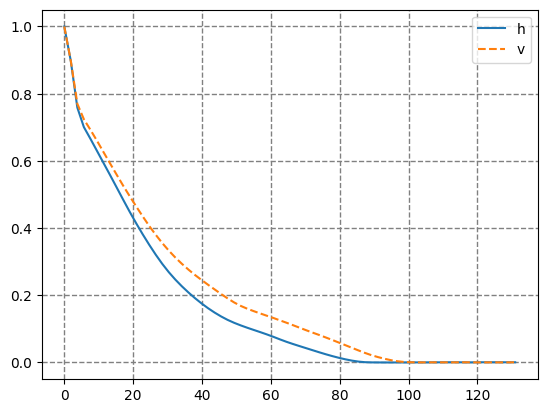

In [77]:
# step 9: MTF
freq_data_h, mtf_data_h = step9_get_mtf(lsf_h, nn2_h, del2_h)
freq_data_v, mtf_data_v = step9_get_mtf(lsf_v, nn2_v, del2_v)
plot_mtf(freq_data_h, mtf_data_h, "h", "-")
plot_mtf(freq_data_v, mtf_data_v, "v", "--")


In [78]:
print(freq_data_h[12], mtf_data_h[12])
print(freq_data_v[12], mtf_data_v[12])
print(step10_get_mtf_interp(mtf_data_h, freq_data_h, 50))
print(step10_get_mtf_interp(mtf_data_v, freq_data_v, 50))

22.77704890121823 0.3816151419934935
22.776940109552427 0.4350245018763834
(50, np.float64(0.11547001560077676))
(50, np.float64(0.1751601121580488))


In [96]:
def my_mtf(filename, topleft1, bottomright1, rot1, topleft2, bottomright2, rot2):
    # step 0: load image
    image = step0_load_image(filename)
    # step 1: get ROI
    roi_image_h, roi = step1_get_roimage(image, topleft1, bottomright1, rot1)
    roi_image_v, roi = step1_get_roimage(image, topleft2, bottomright2, rot2)
    # plot_images(roi_image_h, roi_image_v)

    # step 2: hamming window
    win1_h = get_hamming(roi_image_h.shape[1])
    win1_v = get_hamming(roi_image_v.shape[1])
    # plt.subplot(1, 2, 1)
    # plt.title("hamming window")
    # plt.plot(win1_h)
    # plt.subplot(1, 2, 2)
    # plt.title("hamming window v")
    # plt.plot(win1_v)

    # step 3: get derivative
    deriv_h = get_derivative(roi_image_h)
    deriv_v = get_derivative(roi_image_v)
    # plot_derivatives(deriv_h)
    # plot_derivatives(deriv_v)

    # step 4: apply window and compute centroid
    centroid_h, fit_h = step4_get_centroid_and_fit(deriv_h, win1_h)
    centroid_v, fit_v = step4_get_centroid_and_fit(deriv_v, win1_v)
    # plt.plot(1, 2, 1)
    # plot_centroid(deriv_h, centroid_h, fit_h)
    # plt.plot(1, 2, 2)
    # plot_centroid(deriv_v, centroid_v, fit_v)

    # step 5: compute polynomial fit to central locations

    roi_image_limited_h, nbin_h, nn2_h, del2_h = step5_fit_central(fit_h, centroid_h, deriv_h, win1_h)
    roi_image_limited_v, nbin_v, nn2_v, del2_v = step5_fit_central(fit_v, centroid_v, deriv_v, win1_v)

    # step 6: super-sample

    esf_h = step6_super_sample(roi_image_limited_h, fit_h, nbin_h)
    esf_v = step6_super_sample(roi_image_limited_v, fit_v, nbin_v)
    # plt.plot(esf_h)
    # plt.plot(esf_v)

    # step 7: compute 1D derivative (LSF)
    lsf1_h = step7_get_lsf(esf_h)
    lsf1_v = step7_get_lsf(esf_v)
    # plt.plot(lsf1_h)
    # plt.plot(lsf1_v)

    # step 8: apply window to LSF

    lsf_h, win3_h = step8_apply_win_to_lsf(lsf1_h)
    lsf_v, win3_v = step8_apply_win_to_lsf(lsf1_v)
    # plt.subplot(1, 2, 1)
    # plt.title("without hamming")
    # plt.plot(lsf_h)

    # plt.subplot(1, 2, 2)
    # plt.title("hamming")
    # plt.plot(lsf1_h * win3_h)
    # plt.plot(win3_h*200)    

    # step 9: MTF
    freq_data_h, mtf_data_h = step9_get_mtf(lsf_h, nn2_h, del2_h)
    freq_data_v, mtf_data_v = step9_get_mtf(lsf_v, nn2_v, del2_v)
    
    return freq_data_h, mtf_data_h,freq_data_v, mtf_data_v


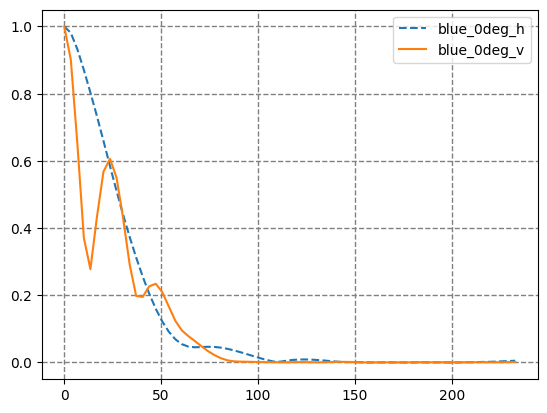

In [97]:
folder = "_s2"
red_data = [
    ("_r_0deg_0mm_offaperture_1333.png", (1014, 990), (1149, 1068), 90, (1152, 822), (1224, 984), 0, "red_0deg"),
    # ("_r_0deg_+2mm_offaperture_1333.png", (1016, 1019), (1176, 1075), 90, (1158, 872), (1228, 998), 0, "red_0deg_+2mm"),
    # ("_r_0deg_-2mm_offaperture_1333.png", (1006, 995), (1162, 1053), 90, (1178, 723), (1226, 944), 0, "red_0deg_-2mm"),
]

red_data = [
    ("_r_-22deg_0mm_offaperture_2222.png", (993, 1041), (1116, 1131), 90, (1128, 882), (1221, 1029), 0, "red_-22deg"),
    # ("_r_-22deg_+2mm_offaperture_4444.png", (1002, 1041), (1143, 1125), 90, (1158, 872), (1223, 1026), 0, "red_-22deg_+2mm"),
    # ("_r_-22deg_-2mm_offaperture_4444.png", (1002, 1047), (1125, 1134), 90, (1134, 912), (1221, 1032), 0, "red_-22deg_-2mm"),
]

red_data = [
    ("_r_+22deg_0mm_offaperture_2666.png", (1044, 864), (1191, 948), 90, (1194, 687), (1275, 846), 0, "red_+22deg"),
    # ("_r_+22deg_+2mm_offaperture_2666.png", (1056, 855), (1182, 936), 90, (1173, 681), (1263, 849), 0, "red_+22deg_+2mm"),
    # ("_r_+22deg_-2mm_offaperture_5555.png", (1008, 918), (1158, 993), 90, (1161, 726), (1248, 909), 0, "red_+22deg_-2mm"),
]

red_data = [
    ("_b_0deg_0mm_offaperture_4444.png", (1020, 1170), (1185, 1260), 90, (1188, 1011), (1278, 1173), 0, "blue_0deg"),
    # ("_b_0deg_+2mm_offaperture_4444.png", (1038, 1197), (1167, 1284), 90, (1170, 1029), (1251, 1197), 0, "blue_0deg_+2mm"),
    # ("_b_0deg_-2mm_offaperture_5555.png", (1038, 1152), (1146, 1245), 90, (1149, 990), (1230, 1152), 0, "blue_0deg_-2mm"),
]

for r in red_data:
    filename = r[0]
    topleft1 = r[1]
    bottomright1 = r[2]
    rot1 = r[3]
    topleft2 = r[4]
    bottomright2 = r[5]
    rot2 = r[6]
    label = r[7]


    freq_data_h, mtf_data_h,freq_data_v, mtf_data_v = my_mtf(f"{folder}/{filename}", topleft1, bottomright1, rot1, topleft2, bottomright2, rot2)

    plot_mtf(freq_data_h, mtf_data_h, f"{label}_h", linestyle="--")
    plot_mtf(freq_data_v, mtf_data_v, f"{label}_v", linestyle="-")